# Advanced Machine Learning Project

---



Autori: Cogo Luca (830045), Confalonieri Riccardo (830404) <br>
E-mail: l.cogo@campus.unimib.it, r.confalonieri5@campus.unimib.it

<h1> Histopatological Cancer Detection </h1>

Il crescente utilizzo negli ultimi anni di immagini digitali in campo medico ha reso possibile l'utilizzo di tecniche di apprendimento automatico per la diagnosi di varie patologie. Si vuole dunque valutare l'efficacia delle più recenti tecniche di deep learning nel diagnosticare tumori al sistema linfatico a partire da immagini realizzate tramite appositi scanner WSI (Whole Slide Image), rese disponibili dal dataset benchmark PatchCamelyon (PCam). A tale scopo verranno descritti diversi approcci: una Convolutional Neural Network addestrata da zero e alcune architetture (VGG16, DenseNet-121, MobileNetV2) basate su modelli pre-trainati per il riconoscimento di immagini (Imagenet). 

## Import delle librerie

In [ ]:
!pip install -q -U keras-tuner # libreria per il tuning degli iperparametri
!pip install -q visualkeras # libreria per visualizzazione dell'architettura


     |████████████████████████████████| 98 kB 3.2 MB/s 


In [ ]:
# caricamento e salvataggio su drive
from google.colab import drive

# lettura file
import pandas as pd
import numpy as np

# per plot immagini
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Polygon
from PIL import Image
import random

import tensorflow as tf
from tensorflow import keras
from keras import layers


# per valutare i risultati
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import time # per valutare tempi di esecuzione

# copia ed esportazione file zip
import zipfile
import shutil
import os
# conteggio numero di esempi per classe
from collections import Counter


from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam, SGD
# salvataggio modelli e early_stopping regularization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model # per ricaricare i modelli
from tensorflow.keras.metrics import Recall # metrica di recall per i modelli
import keras_tuner as kt # libreria per tuning iperparametri


import visualkeras # libreria per visualizzare l'architettura dei modelli

In [ ]:
# caricamento drive
drive.mount('/content/drive', force_remount=True)

# path principale delle cartella
drive_path = '/content/drive/MyDrive/Colab Notebooks/AML/Cogo_Confalonieri_Progetto_AML/'

Mounted at /content/drive


## Data Loader
Dato che le immagini a disposizione sono tante in fase iniziale ci concentriamo solo su una piccola porzione, inoltre sappiamo che il problema è ristretto alla regione centrale di $32x32$ px. Inizio quindi a importare le immagini di training e validation e visualizzarle  evidenziandone la regione d'interesse per il problema. <br>

Per velocizzare il caricamento le immagini necessarie sono già state preventivamente <i>salvate in formato .zip e suddivise in sottocartelle</i>, ognuna contenente una specifica classe. In questo modo è possibile utilizzare i metodi di import di keras che velocizzano ed ottimizzano il caricamento di grandi quantità di immagini. Inoltre durante la fase di subsampling del dataset completo e creazione dello zip si è anche proceduto a <i>bilanciare il numero di immagini</i> per ciascuna classe così da avere dei dati effettivamente pronti per essere passati ad un modello neurale.

In [ ]:
# carico il dataset sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'Data/train_small.zip', 'train_small.zip')
zip = zipfile.ZipFile('train_small.zip')
zip.extractall()
zip.close()
# cancello dalla root lo zip
os.remove('train_small.zip')

In [ ]:
def import_train_validation(img_size = (96,96), val_split = 0.15, batch_size = 64,
                            dataset_path = './train_small'):
  # definisco il generator delle immagini, in questo caso non effettuo alcuna operazione
  # di data augmentation. Le immagini sono solo riscalate nell'intervallo [0,1] con
  # valori float, inoltre preservo un 15% come validation set
  image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                                 validation_split = val_split
                                                                 )

  # carico il training set
  train_set = image_generator.flow_from_directory(
      dataset_path, # path
      class_mode='categorical', # tipo di variabile da predire
      classes = ['0', '1'], # nome delle classi
      color_mode = 'rgb',
      shuffle = True,
      target_size = img_size, # dim. immagini
      batch_size = batch_size, 
      subset = 'training', # carica un subset di training (85%)
      seed = 830045
  )

  validation_set = image_generator.flow_from_directory(
      dataset_path,
      classes = ['0', '1'],
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle = False, # false perchè nel validation non mi interessa l'ordine!
      target_size = img_size,
      batch_size = batch_size,
      subset = 'validation', # carica un subset di validation (15%)
      seed = 830045
  )

  return train_set, validation_set

In [ ]:
train_set, validation_set = import_train_validation()

Found 21326 images belonging to 2 classes.
Found 3762 images belonging to 2 classes.


In [ ]:
# Visualizzo alcune informazioni di base sulle immagini
print('Tipo delle immagini:', type(train_set))
print('Numero di esempi di training:', train_set.samples)
print("Dimensione dell'immagine: " + str(train_set.image_shape))
print("Range di valori dell'immagine ["+ str(train_set[0][0].min()) + "," 
      + str(train_set[0][0].max()) + "]")
print("Tipo dei valori dell'immagine: ", type(train_set[0][0][0][0][0][0]))

# conto le img per classe
counter = Counter(train_set.classes)
print('Numero di esempi per la classe 0:', list(counter.values())[0])
print('Numero di esempi per la classe 1:', list(counter.values())[1])

Tipo delle immagini: <class 'keras.preprocessing.image.DirectoryIterator'>
Numero di esempi di training: 21326
Dimensione dell'immagine: (96, 96, 3)
Range di valori dell'immagine [0.0,1.0]
Tipo dei valori dell'immagine:  <class 'numpy.float32'>
Numero di esempi per la classe 0: 10663
Numero di esempi per la classe 1: 10663


Il dataset caricato è di tipo proprietario di keras, inoltre possiamo notare che gli altri parametri di base corrispondono a quanto ci si aspettava rispetto ai parametri definiti per il caricamento. Inoltre possiamo notare che effettivamente le classi sono bilanciate e che nel training set si hanno a disposizione $10663$ immagini per ogni classe.

### Visual inspection 
Proviamo a visualizzare qualche immagine evidenziandone la regione d'interesse a seconda della label per capire meglio il task da affrontare.

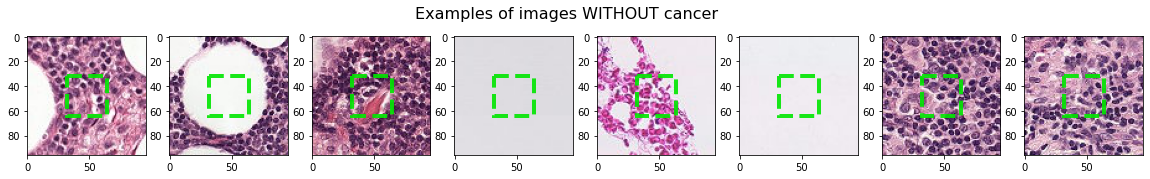

In [ ]:
# immagini senza evidenza di tumore (label = 0)

# plotto 8 figure in una sola riga
fig, ax = plt.subplots(1,8, figsize=(20,5))

# numero di immagini già visualizzate
plotted_img = 0
# lista con indici delle immagini già visualizzate
lst_plotted_img = []

# continuo finchè non ho plottato 8 immagini con label = 0
while plotted_img < 8:
  # prendo un img random dal primo batch
  idx = random.randint(0, 63)

  # se la label dell'immagine è = 0 e non l'avevo ancora estratta la visualizzo
  if (idx not in lst_plotted_img) and (np.argmax(train_set[0][1][idx]) == 0):
    ax[plotted_img].imshow(train_set[0][0][idx])
    # aggiungo un poligono intorno alla regione centrale d'interesse
    p = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
            fc=(0.0, 0.0, 0.0, 0.0), 
            ec=(0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
    ax[plotted_img].add_patch(p)

    # aggiorno il contatore contatore delle img visualizzate
    plotted_img = plotted_img + 1
    # aggiorno la lista con gli indici già visualizzati
    lst_plotted_img.append(idx)


fig.suptitle('Examples of images WITHOUT cancer', y=0.75, fontsize=16)
plt.show()

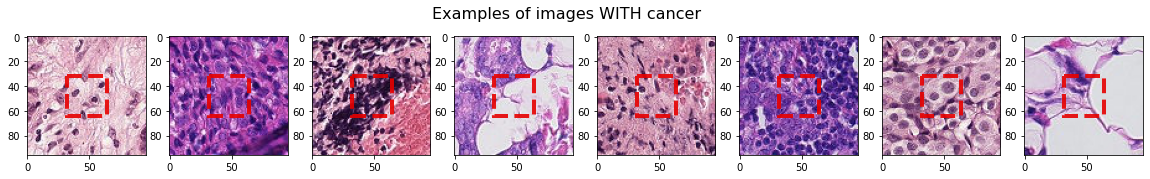

In [ ]:
# immagini con evidenza di tumore (label = 1)

# plotto 8 figure in una sola riga
fig, ax = plt.subplots(1,8, figsize=(20,5))

# numero di immagini già visualizzate
plotted_img = 0
# lista con indici delle immagini già visualizzate
lst_plotted_img = []

# continuo finchè non ho plottato 8 immagini con label = 1
while plotted_img < 8:
  # prendo un img random dal primo batch
  idx = random.randint(0, 63)

  # se la label dell'immagine è = 1 e non l'avevo ancora estratta la visualizzo
  if (idx not in lst_plotted_img) and (np.argmax(train_set[0][1][idx]) == 1):
    ax[plotted_img].imshow(train_set[0][0][idx])
    # aggiungo un poligono intorno alla regione centrale d'interesse
    p = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
            fc=(0.0, 0.0, 0.0, 0.0), 
            ec=(0.9, 0.0, 0.0 ,0.9), lw=4, linestyle='--')
    ax[plotted_img].add_patch(p)

    # aggiorno il contatore contatore delle img visualizzate
    plotted_img = plotted_img + 1
    # aggiorno la lista con gli indici già visualizzati
    lst_plotted_img.append(idx)


fig.suptitle('Examples of images WITH cancer', y=0.75, fontsize=16)
plt.show()

È possibile notare come nelle immagini che non contengono tumore siano presenti anche immagini apparentemente mal digitalizzate che risultano essere completamente bianche o nere. Mentre non sembra esserci un pattern visivo chiaro per distinguere la presenza o meno del tumore (almeno per i non esperti), questo fa capire come il task sia complesso e giustifica quindi un approccio con reti neurali.

### Test set
Carico anche una piccola porzione di test set per poter valutare i modelli che verranno man mano trainati.

In [ ]:
# carico il dataset sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'Data/test_small.zip', 'test_small.zip')
zip = zipfile.ZipFile('test_small.zip')
zip.extractall()
zip.close()
# cancello dalla root lo zip
os.remove('test_small.zip')

# copio anche il csv che contiene le label di riferimento per il test set
shutil.copyfile(drive_path + 'Data/dataset_labels/test_small_label.csv', 'test_small_label.csv')

'test_small_label.csv'

In [ ]:
def import_test(img_size = (96,96), batch_size = 64, dataset_path = './test_small'):
  # definisco lo stesso generator utilizzato in precedenza, con la differenza
  # che in questo caso non è necessario fissare lo split per il validation
  image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

  # carico il test set
  test_set = image_generator.flow_from_directory(
      dataset_path,
      classes = ['-1'], # è stata creata una classe fittizia per poter utilizzare flow_from_directory
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle = False, # false perchè nel validation non mi interessa l'ordine!
      target_size = img_size,
      batch_size = batch_size
  )

  # carico il csv che contiene le label
  df_test = pd.read_csv(dataset_path + '_label.csv')
  df_test = df_test.sort_values(by=['id'])

  # ritorno il test set e un dataframe le label corrispondenti
  return test_set, df_test

## Funzioni utili
Si definiscono alcune funzioni utili, comuni a tutti i modelli che verranno implementati. In questo modo è possibile visualizzare l'andamento del training con il confronto di loss e accuracy sul training e validation set ed anche effettuare le predizioni su un test set visualizzando i risultati in maniera grafica.

In [ ]:
# visualizza a video alcune informazioni testuali di base sul training del modello
# e due grafici per analizzare l'andamento della loss e dell'accuracy durante il training
def resume_model_history(history, early_stop = None):
  # estraggo il numero di epoche nel caso in cui l'early stopping è stato utilizzato
  if early_stop is not None:
    # verifico se l'early stop è entrato in funzione, se si prendo l'epoca in cui
    # si è fermato il training, altrimenti l'epoca migliore (corrisponderà al tot. max delle epoche)
    tot_epoch = early_stop.stopped_epoch+1 if (early_stop.stopped_epoch != 0) else early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  # senza early_stopping l'ultima epoca e la migliore coincidono
  else:
    tot_epoch = len(history.epoch)
    best_epoch = tot_epoch

  # visualizzo i risultati in forma testuale
  print("Numero di epoche totali:", tot_epoch)
  print("Epoca migliore (weights restored):", best_epoch)
  print("Accuracy training set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['accuracy'][best_epoch -1]))
  print("Accuracy validation set all'epoca " + str(best_epoch) + ': '
        + str(history.history['val_accuracy'][best_epoch -1]))
  print("Loss training set all'epoca " + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  print("Loss validation set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][best_epoch -1]))
  
  print('\n\n')

  # visualizzo i grafici di loss e accuracy per training e validation
  fig = plt.figure(figsize =(20, 6))

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'])

  # stesso procedimento per l'accuracy
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Accuracy');  plt.title('Model accuracy')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['accuracy'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_accuracy'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['accuracy'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_accuracy'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'], loc='lower right')

In [ ]:
# Function that allows you to compute and graphically view some
# accuracy metrics on predictions
def evaluate_prediction(model, x_test, y_test):

  # prediction for test set
  y_hat = model.predict(x_test)
  # get the label correspoinding to the top score
  y_hat = y_hat.argmax(axis=1)

  # get the confusion matrix
  cm = confusion_matrix(y_test, y_hat)

  # get the roc curve and auc
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_hat)
  auc_keras = auc(fpr_keras, tpr_keras)


  # get and visualize the classification report
  cl = classification_report(y_test, y_hat) 
  print('\nClassification Report\n', cl)

  # plot beautiful confusion matrix
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu");  

  ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix'); 


  # Plot ROC

  plt.figure()
  plt.plot(fpr_keras,tpr_keras)

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.text(x=0.4, y=0.4 , s = f'AUC: {round(auc_keras,3)}', bbox = dict(boxstyle= 'square', color = 'lightblue'), fontsize = 16)
  plt.show()


  return y_hat, cl

## Ricerca dell'architettura migliore
In questa sezione viene individuata l'architettura ottimale per la rete, facendo uso dell'algoritmo di ottimizzazione Bayesiana. Tutti i tentativi di ottimzzazione vengono eseguiti sul dataset **'small'**. Per la soluzione architetturale con la minor loss verrà anche valutata l'efficacia di tecniche di data augmentation.

In [ ]:
# Inizializzazine di alcuni parametri per la rete
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.001, 
                           verbose=1, restore_best_weights=True) 


initializer = tf.keras.initializers.GlorotUniform(seed=1234) #seed random per garantire replicabilità

input_shape = (96,96,3) # dimensione dell'input
num_classes = 2 #dimensione dell'output

In [ ]:
# Definizione dell'hypermodel che verrà ottimizzato tramite tuning
def model_builder(hp):
  model = keras.models.Sequential()

  model.add(keras.Input(shape = input_shape))

  # DEFINIZIONE DELLA RETE

  hp_num_conv = hp.Int('num_conv', min_value = 1, max_value = 3, step = 1 , default= 3) # Numero di blocchi convoluzionali
  pool_size = (2,2)

  hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu'], default = 'relu') # Funzione di attivazione

  if hp_activation == 'leaky-relu':
    activation = keras.layers.LeakyReLU(alpha=0.01)
  else:
    activation = hp_activation


  hp_filter_1 = hp.Choice('filter_1', values=[32, 64, 128, 256], default = 128) # Dimensione del filter bank del primo blocco
  hp_kernel_size_1 = hp.Choice('kenel_size_1', values = [3, 5], default = 3) # Dimensione del kernel del primo blocco

  model.add(layers.Conv2D(hp_filter_1, hp_kernel_size_1, padding="valid", activation=activation, kernel_initializer=initializer))
  model.add(layers.MaxPool2D(pool_size=pool_size))

  if hp_num_conv >= 2:
    hp_filter_2 = hp.Choice('filter_2', values=[32, 64, 128, 256], default = 128) # Dimensione del filter bank del secondo blocco
    hp_kernel_size_2 = hp.Choice('kenel_size_2', values = [3, 5], default = 3) # Dimensione del kernel del secondo blocco
    
    model.add(layers.Conv2D(hp_filter_2, hp_kernel_size_2, padding="valid", activation=activation, kernel_initializer=initializer))  
    model.add(layers.MaxPool2D(pool_size=pool_size))

  if hp_num_conv >= 3:
    hp_filter_3 = hp.Choice('filter_3', values=[32, 64, 128, 256], default = 128) # Dimensione del filter bank del terzo blocco
    hp_kernel_size_3 = hp.Choice('kenel_size_3', values = [3, 5], default = 3) # Dimensione del kernel del terzo blocco

    model.add(layers.Conv2D(hp_filter_3, hp_kernel_size_3, padding="valid", activation=activation, kernel_initializer=initializer))
    model.add(layers.MaxPool2D(pool_size=pool_size))


  hp_dropout_conv_value = hp.Choice('dropout_conv', values=[0.0, 0.2, 0.5], default = 0.5) # Probabilità di dropout
  if hp_dropout_conv_value != 0:
    model.add(Dropout(hp_dropout_conv_value))

  model.add(layers.Flatten())

  hp_dense = hp.Boolean('dense') # Scelta di aggiungere o meno un ulteriore layer Dense
  if hp_dense:
    hp_dense_size = hp.Choice('dense_size', values=[64, 128, 256], default = 256) # Dimensione del layer denso
    model.add(layers.Dense(hp_dense_size, activation = activation, kernel_initializer= initializer))

    hp_dropout_dense = hp.Choice('dropout_dense', values=[0.0, 0.2, 0.5], default = 0.5) # Probabilità di dropout
    if hp_dropout_dense != 0:
      model.add(Dropout(hp_dropout_dense))


  model.add(layers.Dense(num_classes, activation="sigmoid", kernel_initializer=initializer))


  # Scelta dell'algoritmo di ottimizzazione e del learning rate
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'], default = 'adam')
  optimizer = tf.keras.optimizers.get(hp_optimizer)
  optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default = 1e-3)
                                      


  model.compile(optimizer=optimizer, 
                loss="binary_crossentropy", 
                metrics = ["accuracy", Recall(name = 'recall')])

  return model

Dato che le combinazioni per il tuning sono molte si utilizza l'ottimizzatore bayesiano che permette di non testare tutte le possibili casistiche. Ogni nuova combinazione di iperparametri è infatti definita a partire dalle iterazioni precedenti basandosi sulle probabilità

In [ ]:
# Inizializzazione del tuner
tuner = kt.BayesianOptimization(model_builder,
                                objective=kt.Objective('val_loss', direction="min"),
                                directory=drive_path+'keras_tuner',
                                max_trials = 50, overwrite=False,
                                project_name='model_from_scratch_opt_loss')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/Progetto/keras_tuner/model_from_scratch_opt_loss/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/Progetto/keras_tuner/model_from_scratch_opt_loss/tuner0.json


In [ ]:
# Riassunto dei parametri ottimizzabili
tuner.search_space_summary()

Search space summary
Default search space size: 14
num_conv (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}
filter_1 (Choice)
{'default': 128, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
kenel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filter_2 (Choice)
{'default': 128, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
kenel_size_2 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filter_3 (Choice)
{'default': 128, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
kenel_size_3 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_conv (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.0, 0.2, 0.5], 'ordered': True}
dense (Boolean)
{'default': False, 'conditions': []}
optimi

### Dataset 'small'
Si applica la ricerca dell'architettura migliore utilizzando il dataset small che permette ottimizzazioni più rapide. L'architettura migliore trovata sarà poi addestrata utilizzando anche il dataset medium.

#### Hyperparameter optimization
Tramite l'algoritmo di ottimizzazione Bayesiana, si cerca di individuare la miglior soluzione architetturale

In [ ]:
# Ricerca degli iperparamtri migliori
tuner.search(train_set, epochs=50, validation_data = validation_set, shuffle = True,
             callbacks=[early_stop])

In [ ]:
# Stampa a video dei migliori risultati della ricerca
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/model_from_scratch_opt_loss
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_conv: 3
activation: relu
filter_1: 256
kenel_size_1: 3
filter_2: 256
kenel_size_2: 5
filter_3: 32
kenel_size_3: 3
dropout_conv: 0.5
dense: True
optimizer: adam
learning_rate: 0.0001
dense_size: 256
dropout_dense: 0.5
Score: 0.2639877498149872
Trial summary
Hyperparameters:
num_conv: 3
activation: relu
filter_1: 256
kenel_size_1: 3
filter_2: 256
kenel_size_2: 5
filter_3: 32
kenel_size_3: 3
dropout_conv: 0.5
dense: True
optimizer: adam
learning_rate: 0.0001
dense_size: 128
dropout_dense: 0.5
Score: 0.3070981800556183
Trial summary
Hyperparameters:
num_conv: 3
activation: leaky_relu
filter_1: 32
kenel_size_1: 3
filter_2: 256
kenel_size_2: 5
filter_3: 32
kenel_size_3: 3
dropout_conv: 0.5
dense: True
optimizer: adam
learning_rate: 0.0001
dense_size: 256
dropout_dense: 0.2
S

Visualizziamo i migliori iperparametri individuati dal tuner.

In [ ]:
# Stampa a video degli iperparametri migliori
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'activation': 'relu',
 'dense': True,
 'dense_size': 256,
 'dropout_conv': 0.5,
 'dropout_dense': 0.5,
 'filter_1': 256,
 'filter_2': 256,
 'filter_3': 32,
 'kenel_size_1': 3,
 'kenel_size_2': 5,
 'kenel_size_3': 3,
 'learning_rate': 0.0001,
 'num_conv': 3,
 'optimizer': 'adam'}

Creiamo il nuovo modello con gli iperparametri migliori individuati.

In [ ]:
# Loading the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 256)       1638656   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 32)        73760     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 32)         0

Attraverso la libreria visualKeras plottiamo graficamente la struttura del modello.

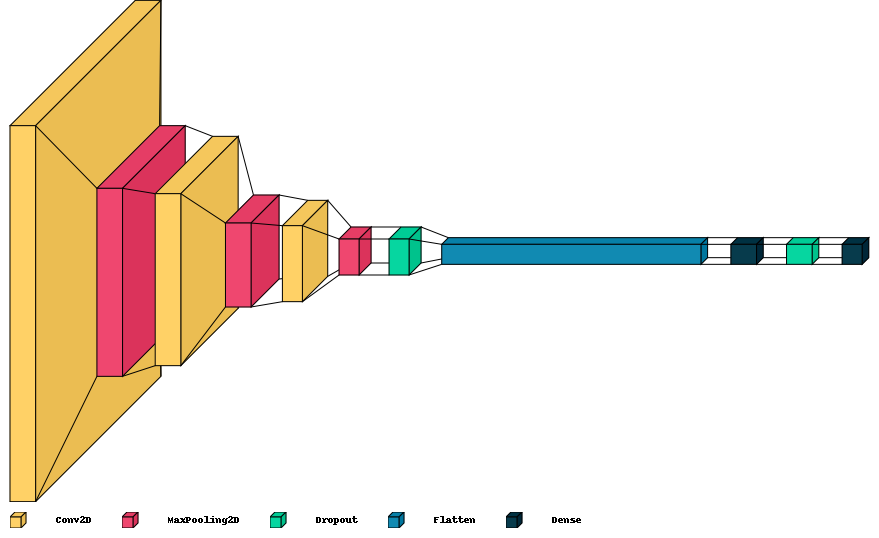

In [ ]:
visualkeras.layered_view(model_tune, legend=True,spacing=30) 

In [ ]:
best_model.save(drive_path + 'Keras_Model/' + 'model_from_scratch_tuned_loss.h5') # Salvataggio del miglior modello trovato dal tuner

Il tuner restituisce un modello già allenato sui parametri migliori, tuttavia è bene rieseguire il training da zero costruendo un nuovo modello. Nel farlo aumentiamo il numero di epoche tornando alla configurazione iniziale di $50$.

In [ ]:
# Training dell'architettura migliore per 50 epoche con EarlyStopping (pazienza=3)
model_tune = tuner.hypermodel.build(best_hps)
history_tune = model_tune.fit(train_set, epochs=50, validation_data = validation_set, 
                              shuffle = True,callbacks=[early_stop])

Epoch 1/50
334/334 [==============================] - 37s 109ms/step - loss: 0.5758 - accuracy: 0.6909 - recall: 0.6916 - val_loss: 0.5057 - val_accuracy: 0.7552 - val_recall: 0.7507
Epoch 2/50
334/334 [==============================] - 36s 109ms/step - loss: 0.4954 - accuracy: 0.7722 - recall: 0.7719 - val_loss: 0.4694 - val_accuracy: 0.7847 - val_recall: 0.7836
Epoch 3/50
334/334 [==============================] - 36s 109ms/step - loss: 0.4817 - accuracy: 0.7774 - recall: 0.7761 - val_loss: 0.4816 - val_accuracy: 0.7772 - val_recall: 0.7757
Epoch 4/50
334/334 [==============================] - 36s 108ms/step - loss: 0.4768 - accuracy: 0.7803 - recall: 0.7792 - val_loss: 0.4395 - val_accuracy: 0.8017 - val_recall: 0.7993
Epoch 5/50
334/334 [==============================] - 36s 109ms/step - loss: 0.4608 - accuracy: 0.7895 - recall: 0.7890 - val_loss: 0.4332 - val_accuracy: 0.8009 - val_recall: 0.8004
Epoch 6/50
334/334 [==============================] - 36s 109ms/step - loss: 0.4533 -

Visualizziamo l'andamento del training rispetto a loss e validation, non si nota particolare presenza di underfitting o overfitting.

Numero di epoche totali: 27
Epoca migliore (weights restored): 24
Accuracy training set all'epoca 24: 0.8876957893371582
Accuracy validation set all'epoca 24: 0.8862307071685791
Loss training set all'epoca 24: 0.27109014987945557
Loss validation set all'epoca 24: 0.27691128849983215





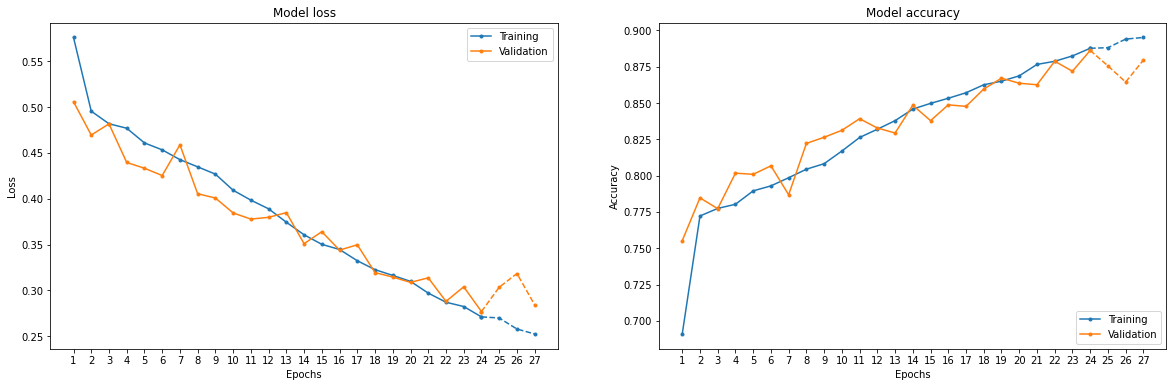

In [ ]:
resume_model_history(history_tune, early_stop)

In [ ]:
model_tune.save(drive_path + 'Keras_Model/' + 'model_from_scratch_tuned_3_loss.h5') # Slavataggio del modello addestrato 

#### Data augmentation
Verranno ora sperimentate tecniche di data augmentation sull'archiettura ottimale individuata nella sezione precedente. Questa scelta è dovuta al fatto che potrebbero aumentare le performance dei modelli e la loro robostuzza rispetto a possibili outlier come le immagini completamente bianche/nere evidenziate nella prima analisi. Le tecniche di augmentation considerate sono: random_flip, random_rotation, random_contrast. Un altro motivo per cui queste tecniche potrebbero essere utili è la diversità di macchinari per estrarre le immagini, ognuno dei quali potrebbe produrre immagini lievemente diverse.


In [ ]:
 #Definizione dell'ipermodello da ottimizzare

def model_builder_augmentation(hp):

model = keras.models.Sequential()

model.add(keras.Input(shape = input_shape))


# ------> AUGMENTATION <------
hp_flip = hp.Boolean('random_flip', default=False)
if hp_flip:
  # flip dell'immagine
  model.add(keras.layers.RandomFlip(mode = "horizontal_and_vertical"))

# rotazione dell'immagine
hp_rotation = hp.Float('random_rotation', min_value=0.0, max_value=0.5, step=0.05)
model.add(keras.layers.RandomRotation(factor =  hp_rotation))

# contrasto randomico
hp_contrast = hp.Float('random_constrast', min_value=0.0, max_value=0.7, step=0.1)
if hp_contrast != 0:
  model.add(keras.layers.RandomContrast(factor = hp_contrast))


# DEFINIZIONE DELLA RETE

hp_num_conv = 3
pool_size = (2,2)

activation = 'relu'

hp_filter_1 = 256
hp_kernel_size_1 = 3

model.add(layers.Conv2D(hp_filter_1, hp_kernel_size_1, padding="same", activation=activation, kernel_initializer=initializer))
model.add(layers.MaxPool2D(pool_size=pool_size))

if hp_num_conv >= 2:
  hp_filter_2 = 256
  hp_kernel_size_2 = 5
  
  model.add(layers.Conv2D(hp_filter_2, hp_kernel_size_2, padding="same", activation=activation, kernel_initializer=initializer))  
  model.add(layers.MaxPool2D(pool_size=pool_size))

if hp_num_conv >= 3:
  hp_filter_3 = 32
  hp_kernel_size_3 = 3

  model.add(layers.Conv2D(hp_filter_3, hp_kernel_size_3, padding="same", activation=activation, kernel_initializer=initializer))
  model.add(layers.MaxPool2D(pool_size=pool_size))


hp_dropout_conv_value = 0.5
model.add(Dropout(hp_dropout_conv_value))

model.add(layers.Flatten())


hp_dense_size = 256
model.add(layers.Dense(hp_dense_size, activation = activation, kernel_initializer= initializer))

hp_dropout_dense = 0.5
model.add(Dropout(hp_dropout_dense))


model.add(layers.Dense(num_classes, activation="sigmoid", kernel_initializer=initializer))


# Tune the learning rate for the optimizer
# Choosing the optimizer and his learning rate
hp_optimizer = 'adam'
optimizer = tf.keras.optimizers.get(hp_optimizer)
optimizer.learning_rate = 1e-4
                                    

model.compile(optimizer=optimizer, 
              loss="binary_crossentropy", 
              metrics = ["accuracy", Recall(name = 'recall')])

return model

Dato che le combinazioni per il tuning sono molte si utilizza l'ottimizzatore bayesiano che permette di non testare tutte le possibili casistiche. Ogni nuova combinazione di iperparametri è infatti definita a partire dalle iterazioni precedenti basandosi sulle probabilità

In [ ]:
# Inizializzazione del tuner
tuner_augmentation = kt.BayesianOptimization(model_builder_augmentation,
                     objective=kt.Objective('val_loss', direction="min"),
                     directory=drive_path+'keras_tuner',
                     max_trials = 10, overwrite=False,
                     project_name='model_from_scratch_augmentation')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/model_from_scratch_augmentation/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/model_from_scratch_augmentation/tuner0.json


In [ ]:
# Ricerca della configurazione di Data Augmentation migliore
tuner_augmentation.search(train_set, epochs=50, validation_data = validation_set, shuffle = True,
             callbacks=[early_stop])

In [ ]:
# Stampa a schermo dei risultati ottenuti dall'ottimizzazione
tuner_augmentation.results_summary()

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/model_from_scratch_augmentation
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
random_flip: False
random_rotation: 0.5
random_constrast: 0.7000000000000001
Score: 0.26694241166114807
Trial summary
Hyperparameters:
random_flip: False
random_rotation: 0.15000000000000002
random_constrast: 0.6000000000000001
Score: 0.2772427797317505
Trial summary
Hyperparameters:
random_flip: False
random_rotation: 0.15000000000000002
random_constrast: 0.6000000000000001
Score: 0.2842777371406555
Trial summary
Hyperparameters:
random_flip: False
random_rotation: 0.30000000000000004
random_constrast: 0.7000000000000001
Score: 0.29373884201049805
Trial summary
Hyperparameters:
random_flip: True
random_rotation: 0.5
random_constrast: 0.6000000000000001
Score: 0.3392636775970459
Trial summary
Hyperparameters:
random_flip: False
random_rotation: 0.0
random_constrast: 0.

Dai risultati appare evidente che l'utilizzo di tecniche di data augmentation non apporta miglioramenti al modello. Verrà quindi considerata da ora in poi l'architettura priva di layer di augmentation

### Test del modello migliore
In questa sezione verrà ricaricato il modello migliore individuato, ovvero quello risultante dall'ottimizzazione degli iperparametri e senza data augmentation.

In [ ]:
# caricamento del modello
model_tune = keras.models.load_model(drive_path + 'Keras_Model/' + 'model_from_scratch_tuned_3_loss.h5')

In [ ]:
# caricamento del test set
test_set, label_test = import_test(img_size=(96,96))

Found 5000 images belonging to 1 classes.


Proviamo inoltre a valutare il modello rispetto al tempo richiesto per predire una sola immagine, per farlo si effettua la predizione su un batch di $64$ immagini e si media il tempo totale. Ovviamente la tempistica è inficiata dalla potenza di calcolo e dal numero di GPU a disposizione (exe parallela).

In [ ]:
start_time = time.time()

for i in range(test_set.batch_size):
  _ = model_tune.predict(test_set[0][0][i].reshape(1,96,96,3))


print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.047 secondi necessari per predire una singola immagine! ---


Valutiamo dunque il modello sul test set small, ci attendiamo che i risultati siano comparabili con quanto visto nel validation set.


Classification Report
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      2500
           1       0.90      0.86      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



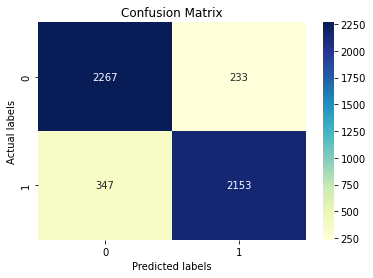

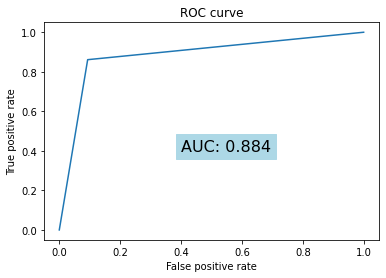

In [ ]:
# model_vgg = keras.models.load_model(drive_path + 'Keras_Model/model_from_scratch_tuned_3_loss.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_tune, test_set, label_test['label'].values)

Come previsto i risultati sono in linea con quelli del validation, evidenziati durante il traning. Le performance sono buone tuttavia la recall per la classe $1$ evidenzia alcuni casi di falsi negativi.

## Training usando il dataset 'medium'
La soluzione architetturale ottimale, trovata nella sezione precedente, viene addestrata e testata sul dataset **'medium'**. Da questo nuovo training ci attendiamo un miglioramento delle performance grazie al numero di immagini maggiore a disposizone del modello

#### Caricamento dati
Carichiamo i dati da drive relativi al dataset medio. Le funzioni di importazione rimangono le medesime precedenti.

In [ ]:
# carico il dataset medium sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'Data/train_medium.zip', 'train_medium.zip')
zip = zipfile.ZipFile('train_medium.zip')
zip.extractall()
zip.close()
# cancello dalla root lo zip
os.remove('train_medium.zip')

In [ ]:
# carico il dataset sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'Data/test_medium.zip', 'test_medium.zip')
zip = zipfile.ZipFile('test_medium.zip')
zip.extractall()
zip.close()
# cancello dalla root lo zip
os.remove('test_medium.zip')

# copio anche il csv che contiene le label di riferimento per il test set
shutil.copyfile(drive_path + 'Data/dataset_labels/test_medium_label.csv', 'test_medium_label.csv')

'test_medium_label.csv'

Importo il dataset di training e test.

In [ ]:
print('Training set:')
# carico le nuove immagini di training, per farlo passo il path specifico della cartella
train_set_med, validation_set_med = import_train_validation(img_size = (96,96), 
                                                            val_split = 0.15, 
                                                            batch_size =  64, 
                                                            dataset_path = './train_medium')

print('\n\nTest set:')
# carico il test set unico per tutti i modelli per poterli valutare coerentemente
test_set_med, label_test_med = import_test(img_size = (96,96), 
                                           batch_size =  64,
                                           dataset_path = './test_medium')

Training set:
Found 85300 images belonging to 2 classes.
Found 15052 images belonging to 2 classes.


Test set:
Found 18000 images belonging to 1 classes.


#### Training
Effettuiamo il training con gli iperparametri precedentemente trovati dopo il tuning.

In [ ]:
# Visualizziamo gli iperparametri migliori
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'activation': 'relu',
 'dense': True,
 'dense_size': 256,
 'dropout_conv': 0.5,
 'dropout_dense': 0.5,
 'filter_1': 256,
 'filter_2': 256,
 'filter_3': 32,
 'kenel_size_1': 3,
 'kenel_size_2': 5,
 'kenel_size_3': 3,
 'learning_rate': 0.0001,
 'num_conv': 3,
 'optimizer': 'adam'}

Ritrainiamo il modello sul nuovo dataset 

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_tune = tuner.hypermodel.build(best_hps)
history_tune = model_tune.fit(train_set_med, epochs=50, validation_data = validation_set_med, 
                              shuffle = True,callbacks=[early_stop])

Epoch 1/50
1333/1333 [==============================] - 349s 249ms/step - loss: 0.5027 - accuracy: 0.7580 - recall: 0.7568 - val_loss: 0.4490 - val_accuracy: 0.8022 - val_recall: 0.8014
Epoch 2/50
1333/1333 [==============================] - 324s 243ms/step - loss: 0.4432 - accuracy: 0.8012 - recall: 0.8005 - val_loss: 0.4035 - val_accuracy: 0.8213 - val_recall: 0.8212
Epoch 3/50
1333/1333 [==============================] - 324s 243ms/step - loss: 0.4077 - accuracy: 0.8210 - recall: 0.8217 - val_loss: 0.3687 - val_accuracy: 0.8406 - val_recall: 0.8413
Epoch 4/50
1333/1333 [==============================] - 324s 243ms/step - loss: 0.3746 - accuracy: 0.8385 - recall: 0.8389 - val_loss: 0.3309 - val_accuracy: 0.8580 - val_recall: 0.8584
Epoch 5/50
1333/1333 [==============================] - 325s 243ms/step - loss: 0.3483 - accuracy: 0.8508 - recall: 0.8508 - val_loss: 0.3108 - val_accuracy: 0.8671 - val_recall: 0.8673
Epoch 6/50
1333/1333 [==============================] - 325s 243ms/ste

Visualizziamo l'andamento della storia del training rispetto a loss e accuracy. Anche in questo caso non si evidenziano particolari problematiche relative ad underfitting o overfitting. Si può però notare un miglioramento delle performance sul validation set. 

Numero di epoche totali: 27
Epoca migliore (weights restored): 24
Accuracy training set all'epoca 24: 0.9426963925361633
Accuracy validation set all'epoca 24: 0.9360882043838501
Loss training set all'epoca 24: 0.15039880573749542
Loss validation set all'epoca 24: 0.16398660838603973





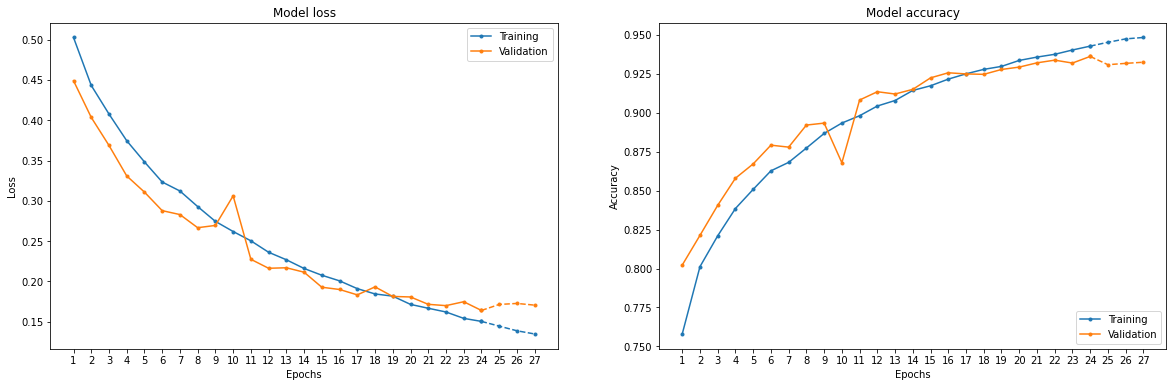

In [ ]:
resume_model_history(history_tune, early_stop)

In [ ]:
# salviamo il modello
model_tune.save(drive_path + 'Keras_Model/' + 'model_from_scratch_medium_loss.h5')

#### Test 
Testiamo il modello creato sul test set medio. 

In [ ]:
# model_tune = keras.models.load_model(drive_path + 'Keras_Model/' + 'model_from_scratch_medium_loss.h5')
model_tune.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 94, 94, 256)       7168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 47, 47, 256)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 43, 43, 256)       1638656   
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 21, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 19, 19, 32)        73760     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 9, 9, 32)        

Carichiamo il nuovo test set.

In [ ]:
test_set, label_test = import_test(img_size=(96,96), batch_size=64, dataset_path='./test_medium')

Found 18000 images belonging to 1 classes.


Come in precedenza valutiamo il tempo di predizione di una singola immagine, che come atteso rimane invariato in quanto l'architettura è la medesima. 

In [ ]:
start_time = time.time()

for i in range(test_set_med.batch_size):
  _ = model_tune.predict(test_set_med[0][0][i].reshape(1,96,96,3))

print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set_med.batch_size, 3))

--- 0.109 secondi necessari per predire una singola immagine! ---


Valutiamo le performance


Classification Report
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      9000
           1       0.93      0.93      0.93      9000

    accuracy                           0.93     18000
   macro avg       0.93      0.93      0.93     18000
weighted avg       0.93      0.93      0.93     18000



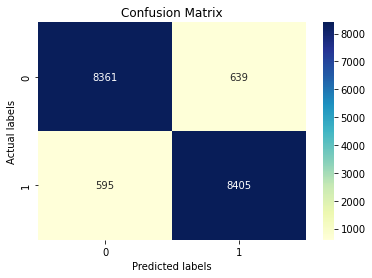

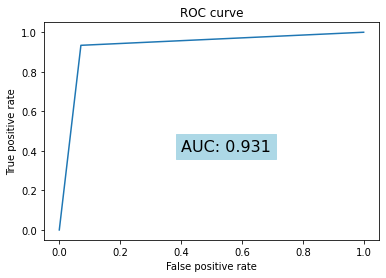

In [ ]:
# model_tune = keras.models.load_model(drive_path + 'Keras_Model/model_from_scratch_medium_loss.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_tune, test_set_med, label_test_med['label'].values)

Anche in questo caso le performance sono in linea con quanto visto sul validation set. Inoltre, come ci si aspettava, gli score sono migliorati rispetto a tutte le metriche analizzate. Si evidenzia comunque una presenza di falsi negativi anche se in percentuale minore rispetto al modello trainato sul dataset small.

## Predizione sul test set kaggle
In questa sezione verrà utilizzato il modello migliore trovato, ovvero la rete from scratch addestrata sul dataset **'medium'**, per predire le immagini presenti nel test set di kaggle. Cosi facendo è possibile caricare le predizioni sulla challenge e ricevere una verifica dei risultati confrondandoci così con gli altri.

In [ ]:
# carico il file zip contenente le immagini da Drive
shutil.copyfile(drive_path + 'Data/test_kaggle.zip', 'test_kaggle.zip')
zip = zipfile.ZipFile('test_kaggle.zip')
zip.extractall('./test_kaggle')
zip.close()
# cancello dalla root lo zip
os.remove('test_kaggle.zip')

Carico il nuovo dataset, per farlo definisco un nuovo loader locale in quanto la struttura della cartella è diversa da quella utilizzata finora. I dati infatti non sono inseriti in un ulteriore sottocartella.

In [ ]:
# carico il dataset di kaggle dalla cartella
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# carico il test set
test_kaggle = image_generator.flow_from_directory(
    './test_kaggle',
    color_mode = 'rgb',
    class_mode = None,
    classes=[''], # classe fittizzia
    shuffle = False,
    target_size = (96,96),
    batch_size = 64
)

Found 57458 images belonging to 1 classes.


Si hanno a disposizione $57458$ immagini su cui effettuare la predizione. I risultati ci attendiamo siano simili a quelli ottenuti sul test set medium.

In [ ]:
# carico il modello pre-trainato
model_kaggle = keras.models.load_model(drive_path + 'Keras_Model/model_from_scratch_medium_loss.h5', compile=False)

In [ ]:
# utilizzo il modello sul test set di kaggle ed estraggo le predizioni
y_pred_kaggle = model_kaggle.predict(test_kaggle)
# estraggo la label corrispondente come valore binario
y_pred_kaggle = y_pred_kaggle.argmax(axis=1)

Creo il file per le previsioni come da specifiche kaggle.

In [ ]:
# creo un dataframe per la submission contenente nome file, previsione
submission = pd.DataFrame(columns = ['id', 'label'])
# estraggo i nomi del file senza estensione .tif
lst_temp = [os.path.splitext(x)[0] for x in test_kaggle.filenames]
submission['id'] = lst_temp # colonna col nome del file
submission['label'] = y_pred_kaggle # colonna con le previsioni

Salvo il file csv per poterlo caricare su kaggle.

In [ ]:
# scarico il file csv con le predizioni
submission.to_csv('kaggle_sub.csv', header = True, index = False)